<a href="https://colab.research.google.com/github/SyedHamadanAhmad/Audio-to-Image-Classification/blob/main/Audio_to_Image_Conversion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

import os
import sys

import librosa
import librosa.display

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint


In [2]:
! pip install -q kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"syedhamadanahmad","key":"c24657ed51974b17b32c2e509fe4188b"}'}

In [4]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio

100% 428M/429M [00:21<00:00, 21.7MB/s]
100% 429M/429M [00:21<00:00, 20.9MB/s]


In [ ]:
!unzip ravdess-emotional-speech-audio.zip


In [8]:
audio_data='audio_speech_actors_01-24'

In [9]:
directory_list= os.listdir(audio_data)
file_emotion=[]
file_path=[]

for dir in directory_list:
  actor=os.listdir(audio_data+'/'+dir)
  for file in actor:
    part=file.split('.')[0]
    part=part.split('-')
    file_emotion.append(int(part[2]))
    file_path.append(audio_data +'/'+dir+'/'+file)



In [10]:
emotions_df=pd.DataFrame(file_emotion, columns=['Emotions'])
path_df=pd.DataFrame(file_path, columns=['Path'])

final_df=pd.concat([emotions_df, path_df], axis=1)


In [11]:
final_df

,Emotions,Path
0,8,audio_speech_actors_01-24/Actor_06/03-01-08-01...
1,6,audio_speech_actors_01-24/Actor_06/03-01-06-01...
2,4,audio_speech_actors_01-24/Actor_06/03-01-04-01...
3,4,audio_speech_actors_01-24/Actor_06/03-01-04-02...
4,5,audio_speech_actors_01-24/Actor_06/03-01-05-01...
...,...,...
1435,2,audio_speech_actors_01-24/Actor_03/03-01-02-01...
1436,6,audio_speech_actors_01-24/Actor_03/03-01-06-01...
1437,8,audio_speech_actors_01-24/Actor_03/03-01-08-02...
1438,4,audio_speech_actors_01-24/Actor_03/03-01-04-01...


In [12]:
final_df.Emotions.replace({1:'Neutral', 2:'Calm', 3:'Happy', 4:'Sad', 5:'Angry', 6:'Fear', 7:'Disgust', 8:'Surprise'}, inplace=True)
final_df

,Emotions,Path
0,Surprise,audio_speech_actors_01-24/Actor_06/03-01-08-01...
1,Fear,audio_speech_actors_01-24/Actor_06/03-01-06-01...
2,Sad,audio_speech_actors_01-24/Actor_06/03-01-04-01...
3,Sad,audio_speech_actors_01-24/Actor_06/03-01-04-02...
4,Angry,audio_speech_actors_01-24/Actor_06/03-01-05-01...
...,...,...
1435,Calm,audio_speech_actors_01-24/Actor_03/03-01-02-01...
1436,Fear,audio_speech_actors_01-24/Actor_03/03-01-06-01...
1437,Surprise,audio_speech_actors_01-24/Actor_03/03-01-08-02...
1438,Sad,audio_speech_actors_01-24/Actor_03/03-01-04-01...


In [13]:
count= final_df['Emotions'].value_counts()
print(count)

Surprise    192
Fear        192
Sad         192
Angry       192
Disgust     192
Happy       192
Calm        192
Neutral      96
Name: Emotions, dtype: int64


In [14]:
data_path=final_df
data_path.to_csv("data_path.csv", index=False)
data_path

,Emotions,Path
0,Surprise,audio_speech_actors_01-24/Actor_06/03-01-08-01...
1,Fear,audio_speech_actors_01-24/Actor_06/03-01-06-01...
2,Sad,audio_speech_actors_01-24/Actor_06/03-01-04-01...
3,Sad,audio_speech_actors_01-24/Actor_06/03-01-04-02...
4,Angry,audio_speech_actors_01-24/Actor_06/03-01-05-01...
...,...,...
1435,Calm,audio_speech_actors_01-24/Actor_03/03-01-02-01...
1436,Fear,audio_speech_actors_01-24/Actor_03/03-01-06-01...
1437,Surprise,audio_speech_actors_01-24/Actor_03/03-01-08-02...
1438,Sad,audio_speech_actors_01-24/Actor_03/03-01-04-01...


In [15]:
def create_emotion_waveplot(data, sample_rate, emotion):
 plt.figure(figsize=(10,3))
 plt.title('Waveplot of {} emotion'.format(emotion), size=15)
 librosa.display.waveshow(data, sr=sample_rate)
 plt.show()


def create_emotion_spectogram(data, sample_rate, emotion):
  X=librosa.stft(data)
  X_db=librosa.amplitude_to_db(abs(X))
  plt.figure(figsize=(10,3))
  plt.title('Spectogram of {} emotion'.format(emotion), size=15)
  librosa.display.specshow(X_db, sr=sample_rate, x_axis='time', y_axis='hz')
  plt.show()


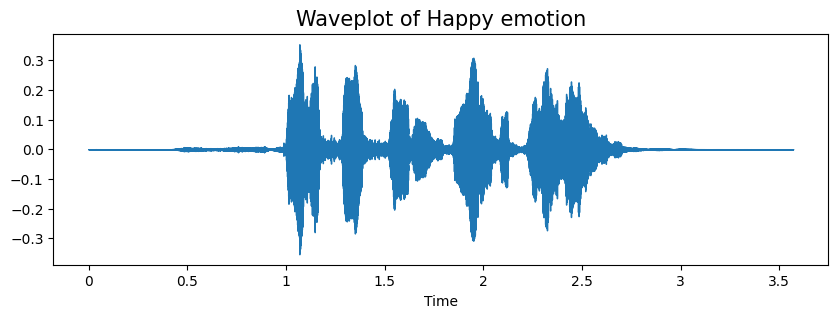

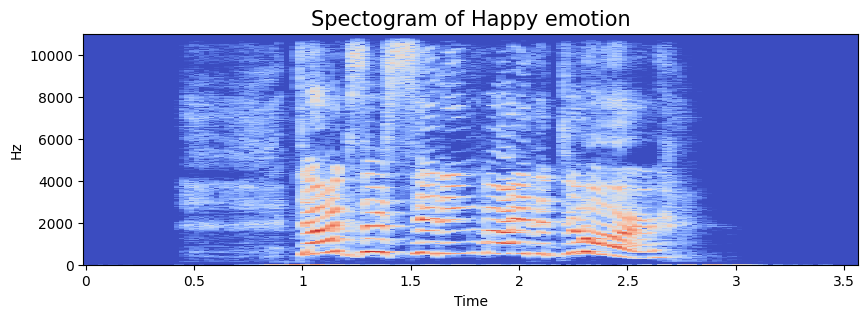

In [16]:
emotion='Happy'
path=np.array(data_path.Path[data_path.Emotions==emotion])[3]
data, sr= librosa.load(path)
create_emotion_waveplot(data, sr, emotion)
create_emotion_spectogram(data, sr, emotion)
Audio(path)

## Data Augmentation

In [17]:
def noise(data):
  noise_amp = 0.035*np.random.uniform()*np.amax(data)
  data=data+ noise_amp*np.random.normal(size=data.shape[0])
  return data

def stretch(data, rate=0.8):
  return librosa.effects.time_stretch(data, rate=rate)

def shift(data):
  shift_range=int(np.random.uniform(low=-5, high=5)*1000)
  return np.roll(data, shift_range)

def pitch(data, sr, pitch_factor=0.7):
  return librosa.effects.pitch_shift(data, sr=sr , n_steps=pitch_factor)


#choosing a random example to check for technique
path=np.array(data_path.Path)[1]
data, sr= librosa.load(path)


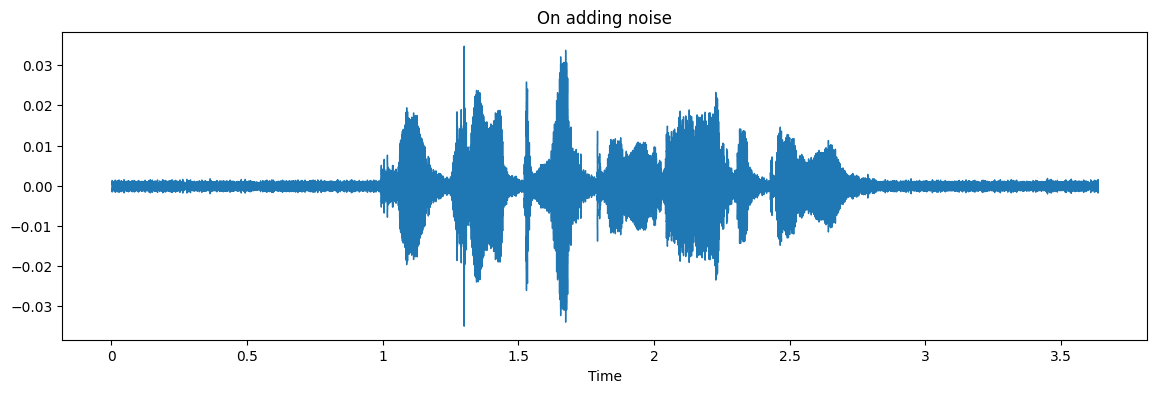

In [18]:
x = noise(data)
plt.figure(figsize=(14,4))
plt.title("On adding noise")
librosa.display.waveshow(y=x, sr=sr)
Audio(x, rate=sr)

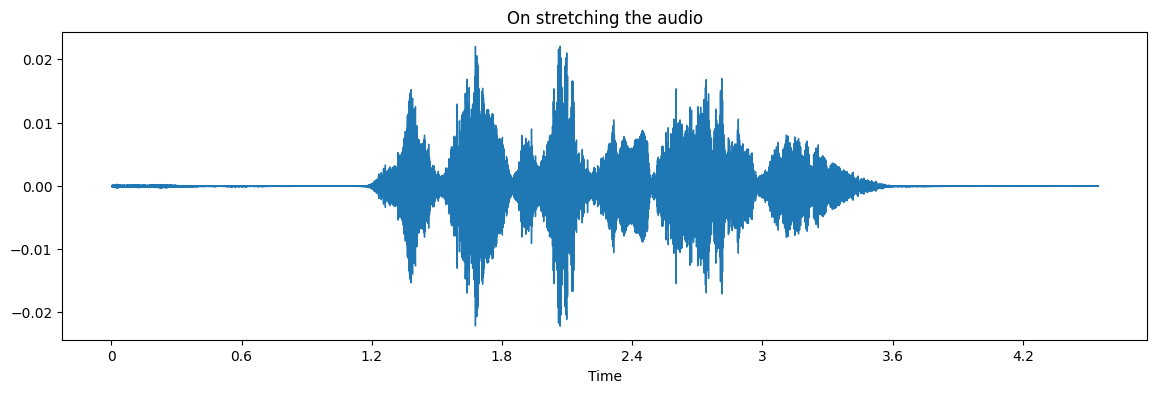

In [19]:
x = stretch(data)
plt.figure(figsize=(14,4))
plt.title("On stretching the audio")
librosa.display.waveshow(y=x, sr=sr)
Audio(x, rate=sr)

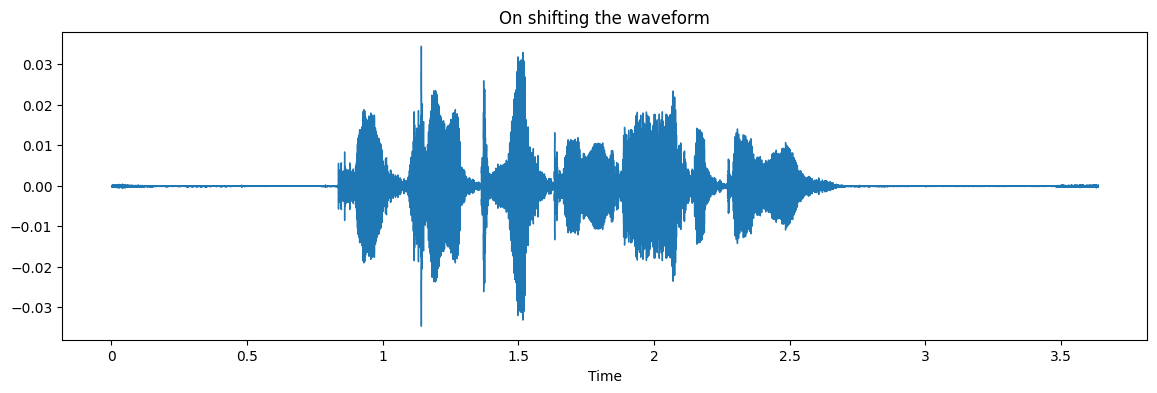

In [20]:
x = shift(data)
plt.figure(figsize=(14,4))
plt.title("On shifting the waveform")
librosa.display.waveshow(y=x, sr=sr)
Audio(x, rate=sr)

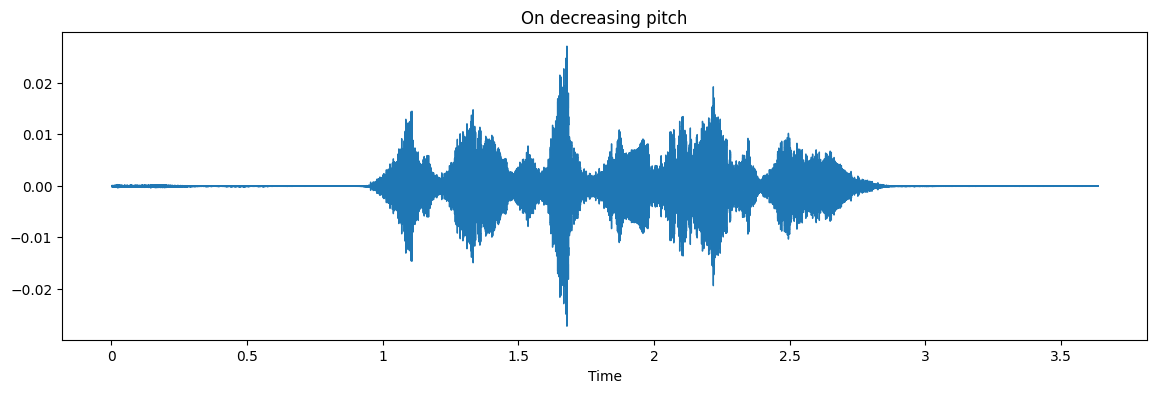

In [21]:
x = pitch(data, sr)
plt.figure(figsize=(14,4))
plt.title("On decreasing pitch")
librosa.display.waveshow(y=x, sr=sr)
Audio(x, rate=sr)

In [22]:
def convert_spectrograms(start, end):
  for ind in final_df.index[start:end]:
    output_directory="Spectrograms/{}".format(final_df['Emotions'][ind])
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    file_base_name=os.path.basename(final_df['Path'][ind])
    output_file_path=os.path.join(output_directory, f"{os.path.splitext(file_base_name)[0]}.png")


    data,sr=librosa.load(final_df['Path'][ind])
    X=librosa.stft(data)
    X_db=librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(10,3))
    librosa.display.specshow(X_db, sr=sr, x_axis='time', y_axis='hz')
    plt.savefig(output_file_path)
    plt.close()
    print("Audio files converted: "+str(ind))

  print("Total converted: "+str(ind+1))




In [23]:
#converting 1000 audio files to spectrograms
convert_spectrograms(0,1000)


Audio files converted: 853
Audio files converted: 854
Audio files converted: 855
Audio files converted: 856
Audio files converted: 857
Audio files converted: 858
Audio files converted: 859
Audio files converted: 860
Audio files converted: 861
Audio files converted: 862
Audio files converted: 863
Audio files converted: 864
Audio files converted: 865
Audio files converted: 866
Audio files converted: 867
Audio files converted: 868
Audio files converted: 869
Audio files converted: 870
Audio files converted: 871
Audio files converted: 872
Audio files converted: 873
Audio files converted: 874
Audio files converted: 875
Audio files converted: 876
Audio files converted: 877
Audio files converted: 878
Audio files converted: 879
Audio files converted: 880
Audio files converted: 881
Audio files converted: 882
Audio files converted: 883
Audio files converted: 884
Audio files converted: 885
Audio files converted: 886
Audio files converted: 887
Audio files converted: 888
Audio files converted: 889
A

In [ ]:
!zip -r /content/Spectrograms.zip /content/Spectrograms
